In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

<Figure size 1200x600 with 0 Axes>

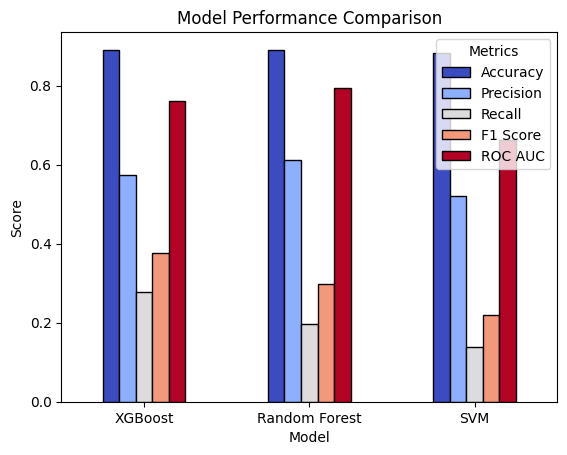

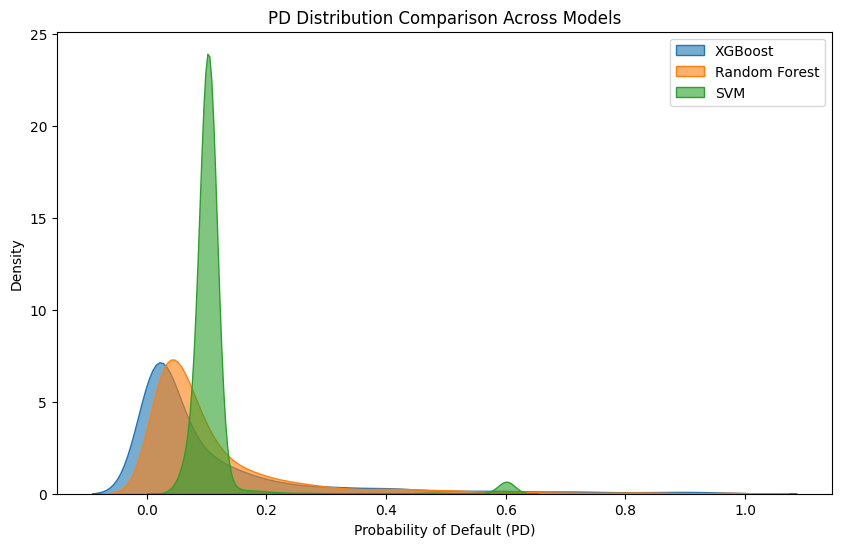

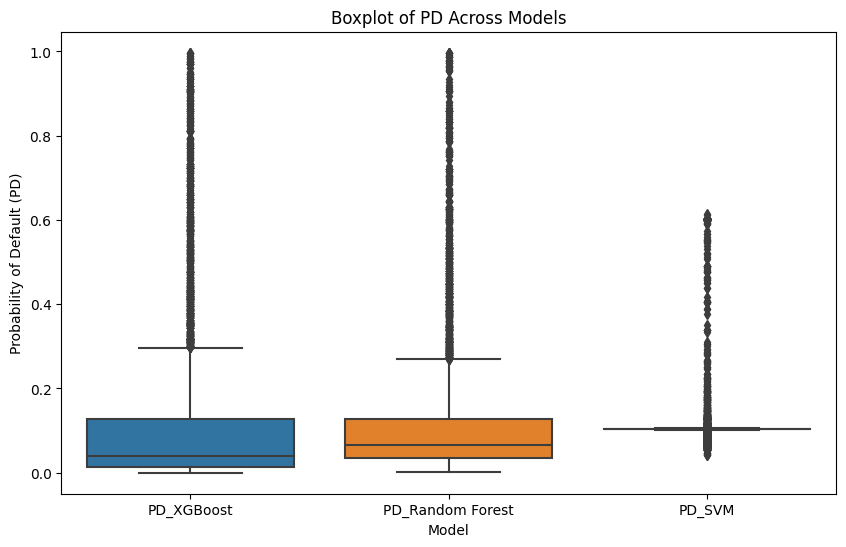

In [4]:
# Load the dataset
dataset_path = r"C:\Users\vagel\Desktop\CR_Risk Project\final_credit_risk_dataset.csv"
data = pd.read_csv(dataset_path)

# Define features (X) and target (y)
X = data.drop(columns=["Credit_Status"])
y = data["Credit_Status"]

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define JSON paths for best hyperparameters
json_paths = {
    "XGBoost": r"C:\Users\vagel\Desktop\CR_Risk Project\xgboost_best_params.json",
    "Random Forest": r"C:\Users\vagel\Desktop\CR_Risk Project\rf_best_params.json",
    "SVM": r"C:\Users\vagel\Desktop\CR_Risk Project\svm_best_params.json"
}

# Load best hyperparameters from JSON files
best_params = {model: json.load(open(path, "r")) for model, path in json_paths.items()}

# Define models dictionary with best parameters
models = {
    "XGBoost": xgb.XGBClassifier(**best_params["XGBoost"], use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"], random_state=42, n_jobs=-1),
    "SVM": SVC(**best_params["SVM"], kernel="rbf", probability=True, random_state=42)
}

# Train models, predict outcomes, and compute performance metrics dynamically
metrics_dict = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "ROC AUC": []
}

pd_values = {"Applicant_ID": X_test.index}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of default

    # Store probability of default
    pd_values[f"PD_{name}"] = y_proba

    # Compute evaluation metrics
    metrics_dict["Model"].append(name)
    metrics_dict["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics_dict["Precision"].append(precision_score(y_test, y_pred))
    metrics_dict["Recall"].append(recall_score(y_test, y_pred))
    metrics_dict["F1 Score"].append(f1_score(y_test, y_pred))
    metrics_dict["ROC AUC"].append(roc_auc_score(y_test, y_proba))

# Convert results to DataFrames
metrics_df = pd.DataFrame(metrics_dict)
pd_comparison = pd.DataFrame(pd_values)


# Plot Performance Metrics
plt.figure(figsize=(12, 6))
metrics_df.set_index("Model").plot(kind="bar", colormap="coolwarm", edgecolor="black")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()

# Plot PD Distributions Across Models
plt.figure(figsize=(10, 6))
for name in models.keys():
    sns.kdeplot(pd_comparison[f"PD_{name}"], label=name, fill=True, alpha=0.6)
plt.xlabel("Probability of Default (PD)")
plt.ylabel("Density")
plt.title("PD Distribution Comparison Across Models")
plt.legend()
plt.show()

# Boxplot for PD Distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd_comparison.drop(columns=["Applicant_ID"]))
plt.xlabel("Model")
plt.ylabel("Probability of Default (PD)")
plt.title("Boxplot of PD Across Models")
plt.show()



# **Probability of Default (PD) Analysis Across Models**

## **Model Performance Comparison**

### **Interpretation**
- This **bar chart** compares the key performance metrics (**Accuracy, Precision, Recall, F1 Score, and ROC AUC**) across **XGBoost, Random Forest, and SVM**.
- **Accuracy** is high for all models, but this can be misleading due to class imbalance.
- **Recall** is the most important metric in credit risk analysis, as it measures how well the model **detects actual defaulters**.
- **Random Forest** has the highest **Recall**, meaning it correctly identifies more defaulters.
- **XGBoost and Random Forest have strong ROC AUC scores**, indicating good model discrimination ability.
- **SVM performs the worst in Recall and F1 Score**, suggesting it is less effective in identifying defaulters.


## **PD Distribution Comparison Across Models**

### **Interpretation**
- This **Kernel Density Estimation (KDE) plot** shows the **distribution of PD values** for each model.
- **XGBoost and Random Forest** produce similar PD distributions, with a **smooth spread of probabilities**.
- **SVM has an extremely sharp peak near 0**, meaning it assigns **very low PD values** to most applicants, failing to differentiate between risky and safe borrowers.
- **Random Forest produces a slightly wider spread of PD values**, making it more effective for identifying high-risk applicants.

### **Mathematical Concept: Probability of Default (PD)**
**PD** is the probability that an applicant will **default on a loan** within a given time period.

$PD = P(Y = 1 | X)$

where:
-  $Y = 1$ represents **default**.
- $X$ represents the set of **financial and behavioral features** used to predict default.


## **Boxplot of PD Across Models**

### **Interpretation**
- This **boxplot** compares the **spread and distribution of PD predictions** across models.
- **XGBoost and Random Forest show a more balanced PD range**, meaning they assign a wider range of probabilities.
- **SVM is overly conservative**, assigning **low PD values** for most applicants.
- **Outliers (dots at the top)** represent applicants assigned **very high PD values**, meaning the models have identified them as **high-risk borrowers**.

### **Mathematical Concept: PD in Risk Bucketing**
PD values are often categorized into **risk buckets**:

| **Risk Category** | **PD Range** |
|------------------|--------------|
| Low Risk | $PD < 10\%$ |
| Medium Risk | 10\% $\leq PD < 40\%$ |
| High Risk |  40\% $\leq PD < 75\%$ |
| Very High Risk | PD $\geq 75\%$  |

This helps financial institutions make **credit decisions** based on risk levels.

---

## **Final Insights**
- **Random Forest is the most effective model** for credit risk prediction, achieving the highest **Recall**.
- **XGBoost provides good PD estimations** but has slightly lower Recall.

### **Next Steps**
- **Expected Loss (EL) calculations**.
- Implement **Threshold Optimization** to improve **Recall-Precision tradeoff**.
